# DA 320

| Key | Value |
|:------------- |:-------------|
| Assignment | Midterm - Jupyter Charts with MongoDB |
| Author | Junguk Park |
| Date | 2022-05-22 |


> ## Introduction
> - Datasets : imdb and metacritic from Mongodb
> - Datasets contain informations about the movies (title, release year, score, and etc.)
> - Rander some charts about movie rating trend, release month, budget, and gross sales
> - boxplot, histogram, and scatterplot

The first code block in your Jupyter notebook should read the mongo DB connection string from your credentials file.

Create a file called "credentials.json" file. It should contain the following text

In [90]:
# %%writefile ./credentials.json
# {
#     "username":"<ID>",
#     "password":"<PASSWORD>",
#     "mongodb":"mongodb+srv://<ID>:<PASSWORD>@cluster0.bomxf.mongodb.net/test"
# }

In [91]:
import json

mongo_conn_str = ""

with open('./credentials.json') as f:
    data = json.load(f)
    mongo_conn_str = data['mongodb']

> In order to use the Mongodb connection string start with `mongodb+srv://` following python library need to be installed.
>
>    ```bash
>    pip install pymongo[srv]
>    ```

The second code block in your Jupyter notebook should connect to the database and print server status.

> In order to run server level command, i.e. `serverStatus`, the user need to have `@admin` role. And this role is given to a user for this test.

In [92]:
import pymongo

# Connect to the database and verify it's working. This prints lots of stuff!
client = pymongo.MongoClient(mongo_conn_str)
db = client.movies
serverStatusResult = db.command("serverStatus")
print(serverStatusResult)

# The collection I want is called "pets"
imdb = db["imdb"]

{'host': 'cluster0-shard-00-01.bomxf.mongodb.net:27017', 'version': '5.0.8', 'process': 'mongod', 'pid': 3091, 'uptime': 351095.0, 'uptimeMillis': 351094586, 'uptimeEstimate': 351094, 'localTime': datetime.datetime(2022, 5, 22, 7, 8, 51, 397000), 'asserts': {'regular': 0, 'warning': 0, 'msg': 0, 'user': 0, 'rollovers': 0}, 'connections': {'current': 6, 'available': 494, 'totalCreated': 954}, 'extra_info': {'note': 'fields vary by platform', 'page_faults': 0}, 'network': {'bytesIn': 2134077, 'bytesOut': 63414252, 'numRequests': 13744}, 'opcounters': {'insert': 1, 'query': 91, 'update': 0, 'delete': 1, 'getmore': 87, 'command': 13564, 'deprecated': {'query': 0, 'getmore': 0}}, 'opcountersRepl': {'insert': 0, 'query': 0, 'update': 0, 'delete': 0, 'getmore': 0, 'command': 0, 'deprecated': {'query': 0, 'getmore': 0}}, 'repl': {'topologyVersion': {'processId': ObjectId('6284860c7ff2f1ae40972178'), 'counter': 6}, 'hosts': ['cluster0-shard-00-00.bomxf.mongodb.net:27017', 'cluster0-shard-00-01.

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt

# Set fig size
sns.set(rc={"figure.figsize":(16, 9)})

# Define a function to parse MPAARating column
def ratingParser(v):
    mpaarating = str(v[0])
    if len((mpaarating).split("::")) > 1:
        return mpaarating.split("::")[0]
    else:
        return v


## Use Aggregation from MongoDB

Use `Aggregation` in MongoDb to add extra Fields.

Add following fields:
- NetRevenue: Subtract `GrossSales` and `Budget` will shows us new revenue of each movie
- Releasedate: New field to indicate date of a movie 
- sinceReleaseYears: indicate how old a movie is


In [94]:
from datetime import datetime
import regex as re

pipeline = [
    {
        '$addFields': {
            'Releasedate': {
                '$concat': [
                    '$ReleaseYear', '-', '$ReleaseMonth', '-', '$ReleaseDay'
                ]
            }
        }
    }, {
        '$addFields': {
            'NetRevenue': {
                '$subtract': [
                    {
                        '$toLong': '$GrossSales'
                    }, {
                        '$toLong': '$Budget'
                    }
                ]
            }
        }
    }, {
        '$addFields': {
            'sinceReleaseYears': {
                '$toInt': 
                    {
                    '$divide': [
                        {
                            '$subtract': [
                                datetime.utcnow(), {
                                    '$toDate': '$Releasedate'
                                }
                            ]
                        }, 1000 * 60 * 60 * 24 * 31 * 12
                    ]
                }
            }
        }
    },{
        '$addFields': {
            'Rating': {
                '$toDouble': '$Rating'
            }
        }
    },{
        '$addFields': {
            'Runtime': {
                '$toInt': '$Runtime'
            }
        }
    },{
        '$addFields': {
            'Votes': {
                '$toInt': '$Votes'
            }
        }
    },{
        '$addFields': {
            'Budget': {
                '$toLong': '$Budget'
            }
        }
    }
]

df = pd.DataFrame(list(imdb.aggregate(pipeline)))
df = df.sort_values(by="NetRevenue", ascending=False)
# df[["MPAARating"]].fillna("Not Rated", inplace=True)
df[["MPAARating"]]= df[["MPAARating"]].apply(ratingParser, axis=1)
df.head(5)


,_id,ID,Title,Runtime,Rating,Votes,MPAARating,ReleaseYear,ReleaseMonth,ReleaseDay,...,Company3,Releasedate,NetRevenue,sinceReleaseYears,Company4,Company5,Director2,Director3,Director4,Director5
125,6270c51ffdcfb4792d78c40f,4154796,Avengers: Endgame,181.0,8.6,569782.0,PG-13,2019,4,22,...,NaN,2019-4-22,2.440274e+09,3,NaN,NaN,Joe Russo,NaN,NaN,NaN
312,6270c51ffdcfb4792d78c417,4154756,Avengers: Infinity War,149.0,8.5,712222.0,PG-13,2018,4,23,...,South Pictures,2018-4-23,1.727710e+09,4,NaN,NaN,Joe Russo,NaN,NaN,NaN
273,6270c51ffdcfb4792d78c42e,848228,The Avengers,143.0,8.0,1201420.0,TV-14,2012,4,11,...,NaN,2012-4-11,1.299558e+09,9,NaN,NaN,NaN,NaN,NaN,NaN
274,6270c51ffdcfb4792d78c439,2395427,Avengers: Age of Ultron,141.0,7.3,683755.0,PG-13,2015,4,13,...,NaN,2015-4-13,1.155414e+09,6,NaN,NaN,NaN,NaN,NaN,NaN
254,6270c51ffdcfb4792d78c422,1825683,Black Panther,134.0,7.3,543390.0,PG-13,2018,1,29,...,NaN,2018-1-29,1.147071e+09,4,NaN,NaN,NaN,NaN,NaN,NaN


Following shows the recent movies.

A few interesting things are:
* 

<AxesSubplot:xlabel='sinceReleaseYears', ylabel='NetRevenue'>

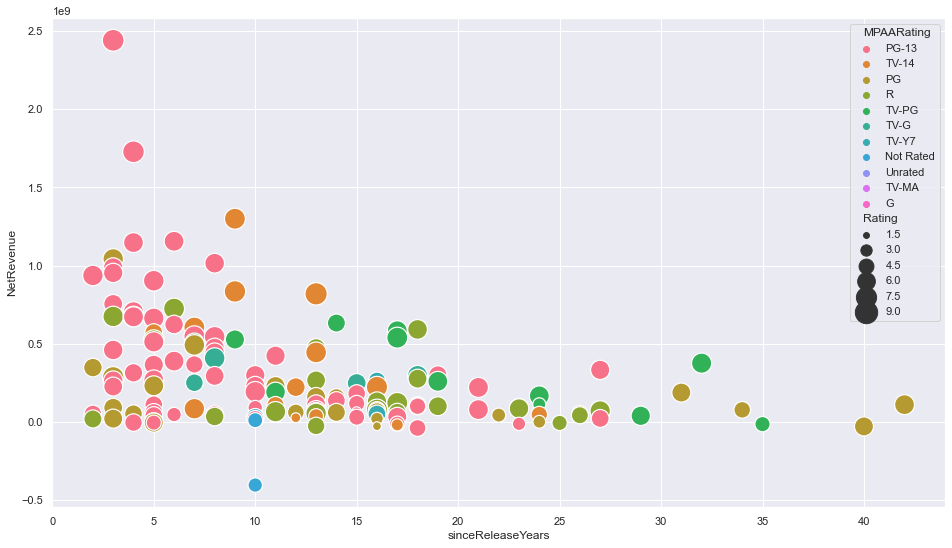

In [95]:
sns.scatterplot(data=df, x="sinceReleaseYears", y="NetRevenue", hue="MPAARating", size="Rating", sizes=(10,500) )

In [104]:
#How the MPAARAting changes over time
# 
# df.groupby("MPAARating").agg("sinceReleaseYears").count("MPAARating")


### Net revenue top 5 movies

The top 5 movies are from Marvel corp.

In [96]:
df[["Title", "NetRevenue","Releasedate"]].head(5)

,Title,NetRevenue,Releasedate
125,Avengers: Endgame,2.440274e+09,2019-4-22
312,Avengers: Infinity War,1.727710e+09,2018-4-23
273,The Avengers,1.299558e+09,2012-4-11
274,Avengers: Age of Ultron,1.155414e+09,2015-4-13
254,Black Panther,1.147071e+09,2018-1-29


### The bottom 5 movies

![](https://upload.wikimedia.org/wikipedia/en/c/c2/Badrinath_poster.jpg)

The worst movie is `Badrinath` which recorded negative 402.8 M revenue.




In [105]:
df[["Title", "NetRevenue","Releasedate"]].sort_values("NetRevenue", ascending=True).head(10)

,Title,NetRevenue,Releasedate
36,Badrinath,-402800000.0,2011-6-9
106,Bulletproof Monk,-38039370.0,2003-4-16
80,Superman II,-27970422.0,1980-12-4
103,Son of the Mask,-26447359.0,2005-2-11
134,Punisher: War Zone,-24899964.0,2008-12-4
257,Catwoman,-17897621.0,2004-7-19
7,Howard the Duck,-13333000.0,1986-8-1
157,The Avengers,-11500000.0,1998-8-13
42,Elektra,-10850769.0,2005-1-8
195,The Crow: City of Angels,-5500000.0,1996-8-30


`The Avengers`(1998) is different than `The Avengers`(2012)

![The Avengers:1998](https://upload.wikimedia.org/wikipedia/en/d/d7/The_Avengers_%281998_film%29_poster.jpg)

The Avengers is a 1998 American spy action film directed by Jeremiah Chechik, an adaptation of the 1961–1969 British television series of the same name. 

<AxesSubplot:xlabel='Rating', ylabel='NetRevenue'>

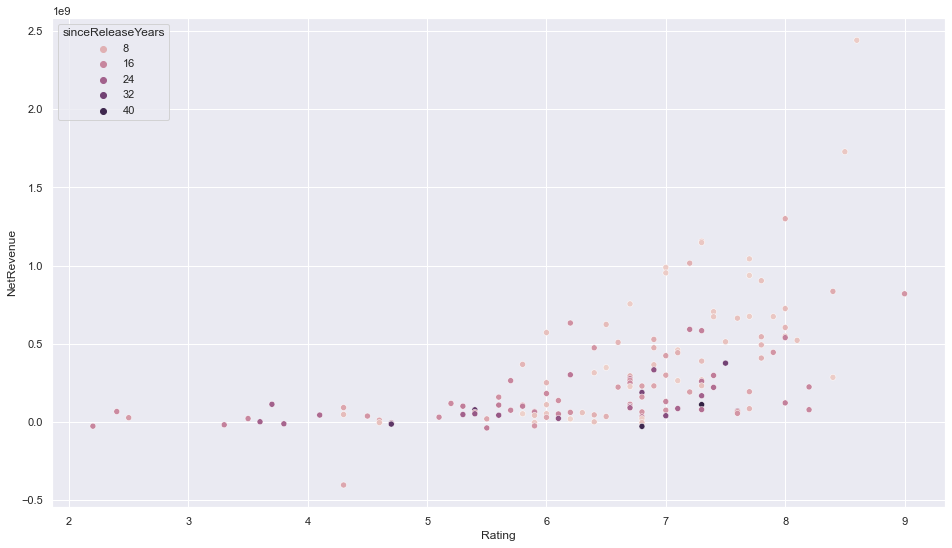

In [143]:
# Better rating more net revenue?
sns.scatterplot(data=df, x="Rating", y="NetRevenue", hue="sinceReleaseYears")

### Use MongoDB aggregation to get total gross sales per year

MongoDB provides built-in function such as group by and sum for fields. 

If it was SQL Server, I could have run following query to get gorss sales for each year. 

```sql
SELECT _id, sum(GrossSales) as totalGrossAmount
FROM imdb
GROUP BY _id
```

But MongoDB use different syntax to run group by query. So the SQL query need to be written as following.
```json
[
    {
        '$group': {
            '_id': '$ReleaseYear', 
            'totalGrossAmount': {
                '$sum': {
                    '$toLong': '$GrossSales'
                }
            }
        }
    }, {
        '$sort': {
            '_id': 1
        }
    }
]
```

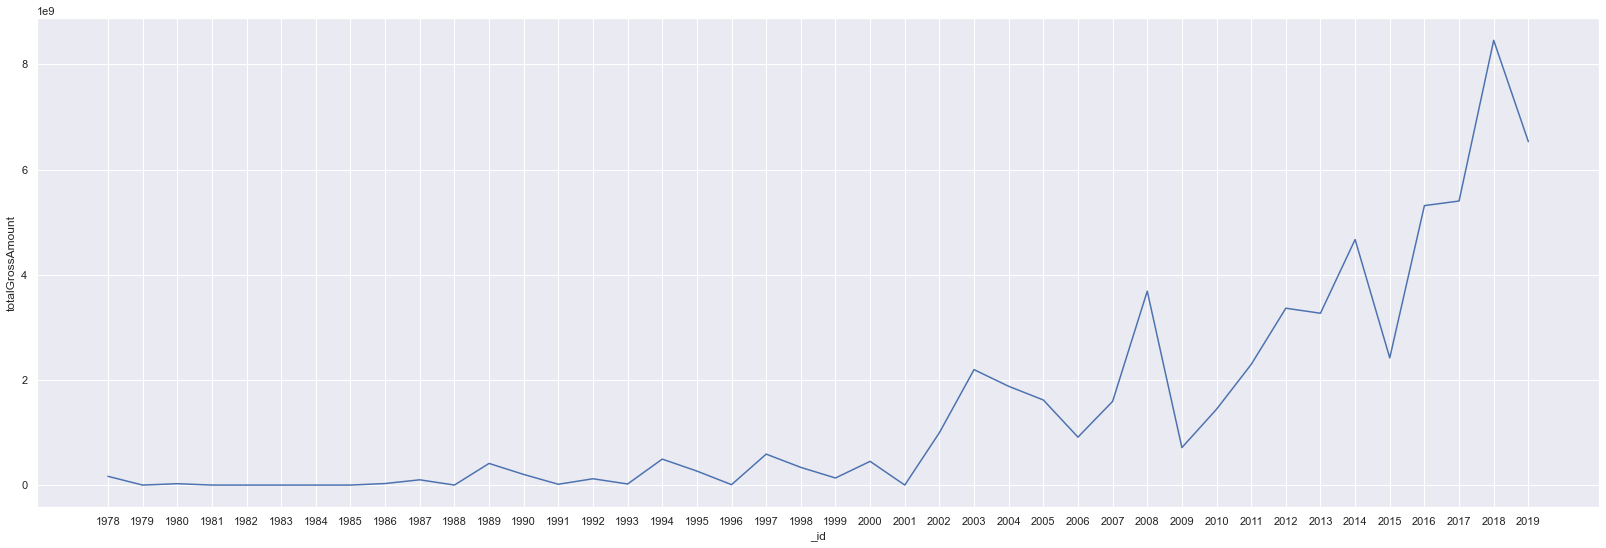

In [108]:
pipeline = [
    {
        '$group': {
            '_id': '$ReleaseYear', 
            'totalGrossAmount': {
                '$sum': {
                    '$toLong': '$GrossSales'
                }
            }
        }
    }, {
        '$sort': {
            '_id': 1
        }
    }
]

sns.set(rc={"figure.figsize":(28, 9)})
sns.lineplot(data=pd.DataFrame(list(imdb.aggregate(pipeline))), x="_id", y="totalGrossAmount")
sns.set(rc={"figure.figsize":(16, 9)})

The chart shows that movie market growth begun 1989. 
Wich movies are there and how is the rating looks like? 
How is average Rating changes over time?

<AxesSubplot:xlabel='ReleaseYear', ylabel='Rating'>

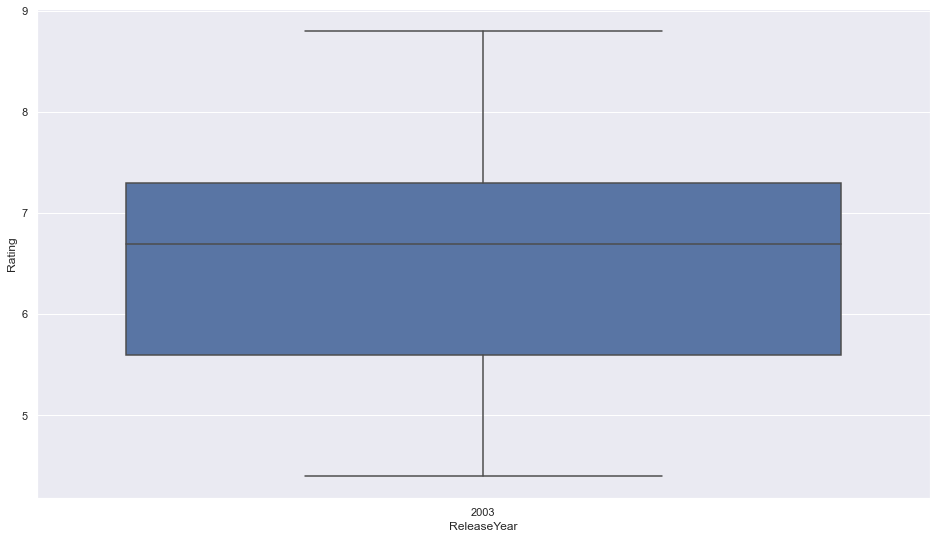

In [122]:
sns.boxplot(data=df[df["ReleaseYear"] == "2003"], x="ReleaseYear",y="Rating")

<AxesSubplot:xlabel='ReleaseYear', ylabel='Rating'>

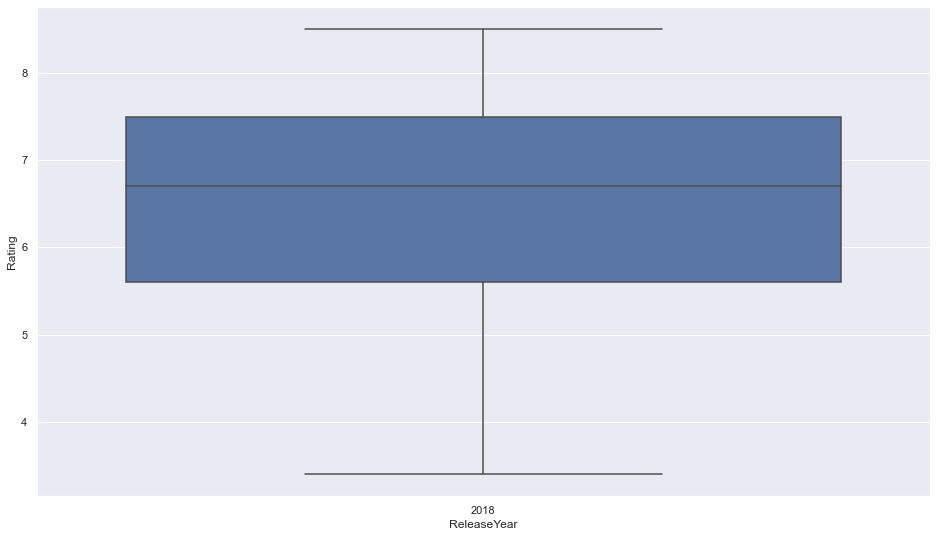

In [123]:
sns.boxplot(data=df[df["ReleaseYear"] == "2018"], x="ReleaseYear",y="Rating")

<AxesSubplot:xlabel='ReleaseYear', ylabel='Rating'>

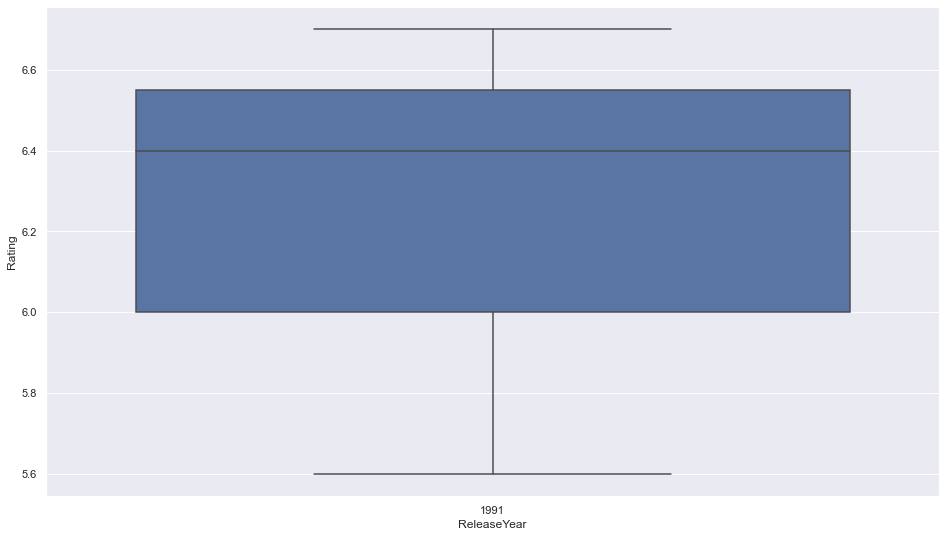

In [118]:
sns.boxplot(data=df[df["ReleaseYear"] == "1991"], x="ReleaseYear",y="Rating")

<AxesSubplot:xlabel='ReleaseYear', ylabel='Rating'>

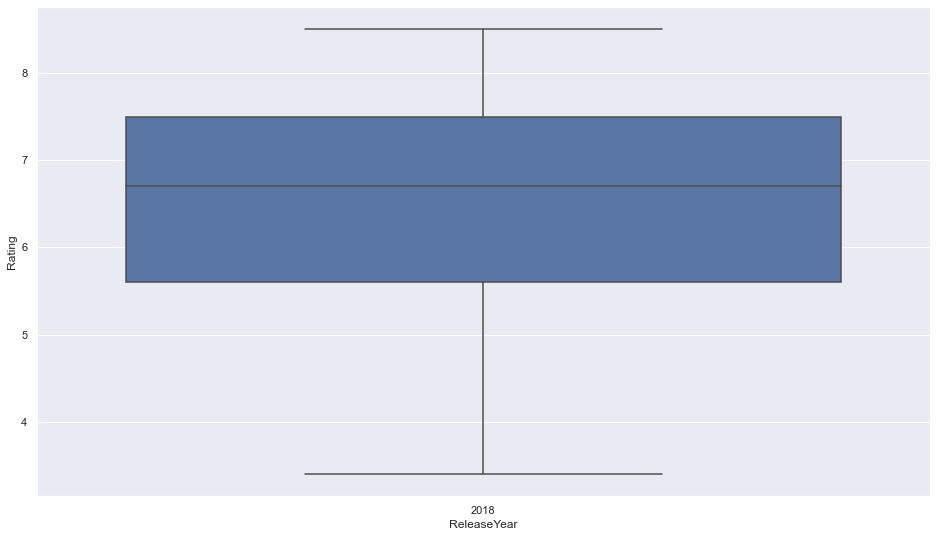

In [115]:
sns.boxplot(data=df[df["ReleaseYear"] == "2018"], x="ReleaseYear",y="Rating")